# Working with API & Web Scraping

#### Load Libraries & Dependencies

In [88]:
import sys, os
from pathlib import Path
sys.path.append("../../scripts")
import requests
import re
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from psycopg2 import sql
import json
from IPython.display import Image, display
from sqlalchemy import Table, Column, Float, text, Integer, String, MetaData, ForeignKey, create_engine
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import undetected_chromedriver as uc
from dotenv import load_dotenv
load_dotenv()


True

## API

### Note

*Stock Market Data API for : [Alpha Vantage](https://www.alphavantage.co/)*

- Algorithmic Trading , Realtime & historical stock market data APIs, Options, forex, crypto & other asset classes
- 60+ technical & economic indicators, Market news API & sentiments, Global coverage

*News API: [newsapi.ai](https://newsapi.ai/)*
- Event Registry builds the world’s leading news analytics for data-driven decisions and operations.

### EtL Case Study 1: :Zuma Realtors [DeprecatedRapidAPI](https://rapidapi.com/realtymole/api/realty-mole-property-api), [NewAPI](https://www.rentcast.io/api)

#### 1. Project Goal Summary

- Business Challenge: Zuma Realtors wants to automate real estate data extraction and turn it into analytics-ready formats.
- *Objectives:*
    >- Automate data collection using APIs (RapidAPI)
    >- Clean, validate, and normalize data (Pandas)
    >- Load to storage formats like PostgreSQL or CSV
    >- Support OLTP normalization and OLAP analytics (fact/dim tables)

#### 2. ETL Pipeline Step

1. API Integration (Already complete in dataset): 
>- Fetch property records using APIs (e.g., RapidAPI) and store raw JSON.

2. Data Cleaning & Transformation (using Pandas)

>- Parse nested JSON columns (features, taxAssessments, propertyTaxes, history, owner)
>- Normalize nested fields into separate structured tables
>- Handle nulls in lastSaleDate, ensure lastSalePrice is float
>- Convert strings like "True"/"False" to booleans where necessary

3. OLTP Normalization
>- Normalize and deduplicate data into related tables (1NF/2NF)
>- Add surrogate keys
>- Maintain referential integrity (owner → property, tax → property, etc.)

4. OLAP Star Schema Design
>- Create dimension tables (location, property, time, owner, etc.)
>- Create a fact table for transactional metrics like sales, tax, etc.

5. Load to PostgreSQL
>- Store normalized OLTP tables under schema: re_zuma_oltp
>- Store dimensional & fact tables under schema: re_zuma_olap

#### Database Model

In [ ]:
display(Image('database model.png'))

#### 3. Extraction: Realty Mole API

In [ ]:
# Extract data from Rentcast API
load_dotenv()
url = "https://api.rentcast.io/v1/properties/random?limit=500"

headers = {
    "accept": "application/json",
    "X-Api-Key": os.getenv("x-rentcastio-key")
}

response = requests.get(url, headers=headers)
print(response.text)

In [ ]:
with open('response_output.json', 'w', encoding='utf-8') as f:
    json.dump(response.json(), f, indent=4)

#### 4. Transformation: Flatten + Normalise

In [8]:
with open('response_output.json') as f:   
    raw_data = json.load(f)

#real_estate_df = pd.json_normalize(raw_data, sep="__")
real_estate_df = pd.DataFrame(raw_data)
print(real_estate_df.columns)
real_estate_df

Index(['id', 'formattedAddress', 'addressLine1', 'addressLine2', 'city',
       'state', 'zipCode', 'county', 'latitude', 'longitude', 'propertyType',
       'bedrooms', 'bathrooms', 'squareFootage', 'lotSize', 'yearBuilt',
       'assessorID', 'legalDescription', 'subdivision', 'lastSaleDate',
       'lastSalePrice', 'features', 'taxAssessments', 'propertyTaxes',
       'history', 'owner', 'ownerOccupied', 'zoning', 'hoa'],
      dtype='object')


,id,formattedAddress,addressLine1,addressLine2,city,state,zipCode,county,latitude,longitude,...,lastSaleDate,lastSalePrice,features,taxAssessments,propertyTaxes,history,owner,ownerOccupied,zoning,hoa
0,"720-Evening-Dr,-Yukon,-OK-73099","720 Evening Dr, Yukon, OK 73099",720 Evening Dr,None,Yukon,OK,73099,Canadian,35.474773,-97.719669,...,2020-12-22T00:00:00.000Z,230000.0,"{'cooling': True, 'coolingType': 'Central', 'e...","{'2019': {'year': 2019, 'value': 22978, 'land'...","{'2019': {'year': 2019, 'total': 2628}, '2020'...","{'2020-12-22': {'event': 'Sale', 'date': '2020...","{'names': ['Tasha Dewitt', 'Joshua Dewitt'], '...",True,NaN,NaN
1,"8011-Wooden-Dr,-Spring-Hill,-FL-34606","8011 Wooden Dr, Spring Hill, FL 34606",8011 Wooden Dr,None,Spring Hill,FL,34606,Hernando,28.490165,-82.581506,...,2005-04-01T00:00:00.000Z,144000.0,"{'cooling': True, 'exteriorType': 'Stucco', 'f...","{'2020': {'year': 2020, 'value': 66590}, '2021...","{'2020': {'year': 2020, 'total': 1077}, '2021'...","{'2005-04-01': {'event': 'Sale', 'date': '2005...","{'names': ['CARL O DAHN', 'JOANNE R DAHN'], 'm...",True,NaN,NaN
2,"3724-8th-St,-Port-Arthur,-TX-77642","3724 8th St, Port Arthur, TX 77642",3724 8th St,None,Port Arthur,TX,77642,Jefferson,29.902562,-93.911105,...,2011-07-18T00:00:00.000Z,NaN,"{'exteriorType': 'Other', 'floorCount': 1, 'fo...","{'2022': {'year': 2022, 'value': 67266, 'land'...","{'2022': {'year': 2022, 'total': 403}, '2023':...","{'2011-07-18': {'event': 'Sale', 'date': '2011...","{'names': ['VU A PHAM'], 'mailingAddress': {'i...",True,NaN,NaN
3,"605-Widick-St,-Colorado-Springs,-CO-80911","605 Widick St, Colorado Springs, CO 80911",605 Widick St,None,Colorado Springs,CO,80911,El Paso,38.751595,-104.726234,...,2020-10-26T00:00:00.000Z,370000.0,"{'architectureType': 'Split Level', 'cooling':...","{'2021': {'year': 2021, 'value': 23800, 'land'...","{'2021': {'year': 2021, 'total': 1862}, '2022'...","{'2020-10-26': {'event': 'Sale', 'date': '2020...","{'names': ['Garry K Ashley', 'Jennifer Kille']...",True,RS-6000 CAD-O,NaN
4,"28710-Diamond-Dr,-Unit-104,-Bonita-Springs,-FL...","28710 Diamond Dr, Unit 104, Bonita Springs, FL...",28710 Diamond Dr,Unit 104,Bonita Springs,FL,34134,Lee,26.318016,-81.810127,...,2013-06-12T00:00:00.000Z,150000.0,"{'architectureType': 'Condo / Apartment', 'flo...","{'2022': {'year': 2022, 'value': 220268, 'impr...","{'2022': {'year': 2022, 'total': 2537}, '2023'...","{'2013-06-12': {'event': 'Sale', 'date': '2013...","{'names': ['BARRY P METZLER', 'CYNTHIA A METZL...",False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,"5635-Regency-Park-Ct,---3800-101,-Suitland,-MD...","5635 Regency Park Ct, # 3800-101, Suitland, MD...",5635 Regency Park Ct,# 3800-101,Suitland,MD,20746,Prince George's,38.838421,-76.909447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,"580-S-Sapodilla-Ave,-Apt-207,-West-Palm-Beach,...","580 S Sapodilla Ave, Apt 207, West Palm Beach,...",580 S Sapodilla Ave,Apt 207,West Palm Beach,FL,33401,Palm Beach,26.709954,-80.058656,...,2021-03-24T00:00:00.000Z,255000.0,"{'architectureType': 'Condo / Apartment', 'uni...","{'2019': {'year': 2019, 'value': 189534}, '202...","{'2019': {'year': 2019, 'total': 3610}, '2020'...","{'2021-03-24': {'event': 'Sale', 'date': '2021...","{'names': ['Skip Patteuw'], 'type': 'Individua...",True,NaN,NaN
497,"124-Willow-Tree-Ter,-Oneida,-NY-13421","124 Willow Tree Ter, Oneida, NY 13421",124 Willow Tree Ter,None,Oneida,NY,13421,Madison,43.082463,-75.672428,...,2022-07-29T00:00:00.000Z,330000.0,"{'architectureType': 'Ranch', 'cooling': True,...","{'2023': {'year': 2023, 'value': 201300, 'land...",NaN,"{'2022-07-29': {'event': 'Sale', 'date': '2022...","{'names': ['Barbara J Eubanks'], 'type': 'Indi...",True,R1,NaN
498,"550-S-Ocean-Blvd,-Apt-705S,-Boca-Raton,-FL-33432","550 S Ocean Blvd, Apt 705S, Boca Raton, FL 33432",550 S Ocean Blvd,Apt 705S,Boca Raton,FL,33432,Palm Beach,26.344262,-80.071525,...,NaN,NaN,NaN,NaN,NaN,NaN,N

##### Clean + Fill NAs

In [ ]:
null_columns = real_estate_df.columns[real_estate_df.isnull().any()]
print(null_columns)

In [ ]:
real_estate_df.fillna({
    **{col: '1900-01-01' for col in real_estate_df.columns if 'date' in col.lower()},
    **{col: 1900 for col in real_estate_df.columns if 'year' in col.lower()},    
    **{col: 0.0 for col in real_estate_df.select_dtypes('float').columns if 'year' not in col.lower()},
    **{col: 'Unknown' for col in real_estate_df.select_dtypes('object').columns if 'year' not in col.lower()}
}, inplace=True)
null_columns = real_estate_df.columns[real_estate_df.isnull().any()]
print(null_columns)

In [ ]:
real_estate_df[['features', 'owner', 'history', 'taxAssessments', 'propertyTaxes']].astype(str)
real_estate_df['lastSaleDate'] = pd.to_datetime(real_estate_df['lastSaleDate'], errors='coerce').dt.tz_localize(None)
real_estate_df['yearBuilt'] = pd.to_numeric(real_estate_df['yearBuilt'], errors='coerce').dropna().astype(int)

In [ ]:
print(real_estate_df.info())
display(real_estate_df.head(3))

####  5. Normalise to OLTP-like dimension and fact tables

##### **OLAP Dimensional Modeling**

| Table          |    Type   |       Role               |
| -------------- | ----------|--------------------- |
| `location_dim` | Dimension | Address + geo info              |
| `sales_dim`    | Dimension | Last sale date + price          |
| `features_dim` | Dimension | Physical & structural details   |
| `date_dim`     | Dimension | Dates for sale, tax, assessment |
| `owner_dim`    | Dimension  | Owner type, names, mailing address         |
| `tax_dim`|Dimension| tax assessment and propertytax|
| `property_fact_table` | **Fact**  | FK: `location_sk`, `sales_sk`, `features_sk` ,`owner_sk`, `tax_sk`+ measures like price, value |

##### *dimensions to be created:*

In [ ]:
# 1. location_dim
location_cols = ['id','addressLine1', 'addressLine2', 'city', 'state', 'zipCode', 'formattedAddress', 'county', 'longitude', 'latitude', 'zoning', 'hoa']
location_df = real_estate_df[location_cols].copy()
location_df = location_df.astype(str)  # convert all to string for safe hashing
location_df = location_df.drop_duplicates().reset_index(drop=True)
location_df.insert(0, 'location_sk', location_df.index + 1) # Add a surrogate key

# location_df has no metrics - copy as is
dm_location = location_df.copy()
display(dm_location.head(5))

In [ ]:
# 2. sales_dim with sale_date_id
sales_cols = ['id','lastSalePrice', 'lastSaleDate']
sales_df = real_estate_df[sales_cols].dropna(subset=["lastSaleDate"]).drop_duplicates().copy()
sales_df.insert(0, 'sales_sk', sales_df.index + 1) # Adding a surrogate key
sales_df.head(5)


In [ ]:
# 3. features_dim (expanded)
# Combine core structural features with nested ones per row
combined_feature_records = []

for idx, row in real_estate_df.iterrows():
    base = {
        "id": row.get("id"),
        "yearBuilt": row.get("yearBuilt"),
        "bedrooms": row.get("bedrooms"),
        "bathrooms": row.get("bathrooms"),
        "squareFootage": row.get("squareFootage"),
        "lotSize": row.get("lotSize")
    }
    features = row.get("features")
    if isinstance(features, dict):
        combined = {**base, **features}
    else:
        combined = base
    combined_feature_records.append(combined)

# Create unified features dimension
features_df = pd.DataFrame(combined_feature_records).drop_duplicates().reset_index(drop=True)
features_df.insert(0, 'features_sk', features_df.index + 1) # Adding a surrogate key
features_df.fillna(
    {
        **{col: 0.0 for col in features_df.select_dtypes('float').columns},
        **{col: 'Notprovided' for col in features_df.select_dtypes('object').columns},
        **{col: 'False' for col in features_df.select_dtypes('bool').columns},
    },
    inplace=True
)

# features_df has only yearBuilt_date_id as a FK, the rest are attributes
dm_features = features_df.drop(columns=[], errors='ignore').copy()
display(dm_features.head(5))

In [ ]:
# 4. owner_dim
real_estate_df['owner'] = real_estate_df['owner'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip().startswith('{') else x
)
owner_records = []

for idx, row in real_estate_df.iterrows():
    owner_data = row['owner']
    if not isinstance(owner_data, dict):
        continue

    owner_names = owner_data.get("names", [])
    combined_names = ", ".join(owner_names) if owner_names else "Notprovided"

    record = {
        "id": row["id"],
        "owner_name": combined_names,
        "owner_type": owner_data.get("type", "Notprovided")
    }
    owner_records.append(record)

owner_df = pd.DataFrame(owner_records).drop_duplicates().reset_index(drop=True)
owner_df.insert(0, 'owner_sk', owner_df.index + 1)
owner_df.fillna("Notprovided", inplace=True)

# owner_df has no metrics - copy as is
dm_owner = owner_df.copy()
display(dm_owner.head(5))

In [ ]:
# 5. tax_dim
# Step 1: Parse nested tax columns safely
real_estate_df['taxAssessments'] = real_estate_df['taxAssessments'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip().startswith('{') else x
)
real_estate_df['propertyTaxes'] = real_estate_df['propertyTaxes'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip().startswith('{') else x
)

# Step 2: Build tax_dim
tax_records = []

for idx, row in real_estate_df.iterrows():
    tax = row["taxAssessments"]
    taxes = row["propertyTaxes"]
    
    if not isinstance(tax, dict) or not isinstance(taxes, dict):
        continue

    for year in set(tax.keys()).union(taxes.keys()):
        tax_record = tax.get(year, {})
        tax_val = taxes.get(year, {})
        record = {
            "id": row["id"],
            "year": int(year),
            "total_value": tax_record.get("value", 0.0),
            "land_value": tax_record.get("land", 0.0),
            "improvements_value": tax_record.get("improvements", 0.0),
            "total_tax": tax_val.get("total", 0.0),
        }
        tax_records.append(record)

tax_df = pd.DataFrame(tax_records).drop_duplicates().reset_index(drop=True)
tax_df.insert(0, 'tax_sk', tax_df.index + 1)
tax_df.head()


In [ ]:
# 6. sales_history dim
real_estate_df['history'] = real_estate_df['history'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip().startswith('{') else x
)
history_records = []

for idx, row in real_estate_df.iterrows():
    hist = row['history']
    prop_id = row['id']
    if isinstance(hist, dict):
        for sale_date, details in hist.items():
            history_records.append({
                "id": prop_id,
                "sale_date": details.get("date", sale_date),
                "sale_price": details.get("price", 0.0),
                "event": details.get("event", "Notprovided"),
            })
sales_history_df = pd.DataFrame(history_records)
sales_history_df["sale_date"] = pd.to_datetime(sales_history_df["sale_date"], errors="coerce").dt.tz_localize(None)
sales_history_df.insert(0, "sales_history_sk", sales_history_df.index + 1)
sales_history_df


##### *date_dim table and df mapping*

In [ ]:
# 1. Create date from lastSaleDate
sales_dates = sales_df['lastSaleDate'].dropna().astype(str).str[:10]
sales_dates = pd.to_datetime(sales_dates, errors='coerce')

sales_history_date= sales_history_df['sale_date'].dropna().astype(str).str[:10]
sales_history_date = pd.to_datetime(sales_history_date, errors='coerce')

# 2. Create date from yearBuilt
yearbuilt_dates = pd.to_datetime(features_df['yearBuilt'].dropna().astype(int).astype(str) + '-01-01', errors='coerce')

# 3. Create date from tax_df['year'] (if not already created)
tax_dates = pd.to_datetime(tax_df['year'].astype(int).astype(str) + '-01-01', errors='coerce')

# 4. Combine and deduplicate
all_dates = pd.concat([yearbuilt_dates, tax_dates,sales_history_date ,sales_dates]).dropna().drop_duplicates().reset_index(drop=True)

# 5. Build date_dim DataFrame
date_dim = pd.DataFrame({"date": all_dates})
date_dim["date_id"] = date_dim["date"].dt.strftime("%Y%m%d")
date_dim["year"] = date_dim["date"].dt.year
date_dim["month"] = date_dim["date"].dt.month
date_dim["month_name"] = date_dim["date"].dt.strftime('%B')
date_dim["quarter"] = date_dim["date"].dt.quarter
date_dim["day"] = date_dim["date"].dt.day
date_dim["day_of_week"] = date_dim["date"].dt.day_name()
date_dim["is_weekend"] = date_dim["date"].dt.weekday >= 5
date_dim["is_month_end"] = date_dim["date"].dt.is_month_end
date_dim

In [ ]:
# Assign date_id back to df and drop the original date columns
date_year_map = date_dim[(date_dim["month"] == 1) & (date_dim["day"] == 1)][["year", "date_id"]] # Create a mapping of year to date_id for year columns

sales_df = sales_df.merge(date_dim[["date", "date_id"]], left_on="lastSaleDate", right_on="date", how="left")
sales_df.drop(columns=["lastSaleDate","date"], inplace=True)
sales_df.rename(columns={"date_id": "sales_date_id"}, inplace=True)

features_df = features_df.merge(date_year_map, left_on="yearBuilt", right_on="year", how="left")
features_df.drop(columns=["yearBuilt", "year"], inplace=True)
features_df.rename(columns={"date_id": "yearBuilt_date_id"}, inplace=True)

tax_df = tax_df.merge(date_year_map, left_on="year", right_on="year", how="left")
tax_df.drop(columns=["year", "year"], inplace=True)
tax_df.rename(columns={"date_id": "tax_year_date_id"}, inplace=True)

sales_history_df = sales_history_df.merge(date_dim[["date", "date_id"]], left_on="sale_date", right_on="date", how="left")
sales_history_df.drop(columns=["sale_date","date"], inplace=True)
sales_history_df.rename(columns={"date_id": "sales_history_date_id"}, inplace=True)

# remove metric (lastSalePrice)
dm_sales = sales_df.drop(columns=["lastSalePrice"], errors='ignore').copy()
display(dm_sales.head(5))

# tax_df - remove all metrics for dimension
dm_tax = tax_df.drop(columns=["total_value", "land_value", "improvements_value", "total_tax"], errors='ignore').copy()
display(dm_tax.head(5))


##### *fact table*

In [ ]:
# Create the fact_property table by joining key/metric columns only
fact_property_df = location_df[['id', 'location_sk']].merge(
    features_df[['id', 'features_sk', 'yearBuilt_date_id']], on='id', how='left'
).merge(
    owner_df[['id', 'owner_sk']], on='id', how='left'
).merge(
    tax_df[['id', 'tax_sk', 'tax_year_date_id', 'total_value', 'land_value', 'improvements_value', 'total_tax']], on='id', how='left'
).merge(
    sales_df[['id', 'sales_sk', 'lastSalePrice', 'sales_date_id']], on='id', how='left'
)
fact_property_df= fact_property_df.drop(columns=['id'], errors='ignore')
fact_property_df = fact_property_df[['location_sk', 'owner_sk', 'tax_sk','features_sk', 'sales_sk','yearBuilt_date_id', 
       'tax_year_date_id',  'sales_date_id', 'total_value', 'land_value', 'improvements_value',
       'total_tax',  'lastSalePrice']]
print(fact_property_df.columns)
display(fact_property_df.head(5))

# Fact sales history already clean
fact_sales_history_df = location_df[['id', 'location_sk']].merge(
    sales_history_df[['id', 'sales_history_sk', 'sales_history_date_id', 'sale_price', 'event']], on='id', how='left'
)
fact_sales_history_df= fact_sales_history_df.drop(columns=['id'], errors='ignore')
fact_sales_history_df = fact_sales_history_df[['location_sk', 'sales_history_sk', 'sales_history_date_id', 'sale_price', 'event']]
display(fact_sales_history_df.head(5))

In [ ]:
# List of DataFrame variable names
dataframes = (
    "dm_location",  # location_dim
    "dm_sales",     # sales_dim
    "dm_features",  # features_dim
    "dm_owner",     # owner_dim
    "dm_tax",       # tax_dim
    "date_dim" ,      # date_dim
    "fact_property_df",  # fact_property
    "fact_sales_history_df",  # fact_sales_history
)

# Display columns of each DataFrame
for df_name in dataframes:
    df = globals().get(df_name)
    if df is not None:
        print(f"\n{df_name} columns:\n{df.columns.tolist()}")
        display(df.head(3))
    else:
        print(f"\n⚠️ {df_name} not found.")

#### 6. Loading Layer

### Case Study 2: Extraction with pagination : [Zoopla Property API](https://rapidapi.com/apidojo/api/zoopla)

##### Notes

**Endpoints**
/properties
/listings/sale
/listings/rental/long-term

*Using the limit Query Parameter*
- control the number of results returned by these endpoints using the limit query parameter, which can be any number between 1 and 500. It will default to 50 if not provided.

*Using the offset Query Parameter*
- use the offset parameter to retrieve additional result sets.
- It defaults to 0 if not provided, which indicates that our API should return results starting from the first one.
- The offset query parameter should be a multiple of the limit parameter, and be incremented on each subsequent request. For example, if you are using a limit of 20, the offset should be set to 0 on the first request (or simply omitted), 20 on the second request, 40 on the third, and so on.

>-  When using pagination, it is important to keep all other query parameters (except for offset) the same for each subsequent request to make sure you are paginating through the same list of results.


##### Without Pagination

In [ ]:
load_dotenv()
url = "https://zoopla.p.rapidapi.com/properties/v2/list"

querystring = {
    "locationValue": "Edinburgh, Scotland",
    "locationIdentifier": "edinburgh-county",
    "category": "Any",
    "furnishedState": "Any",
    "includeRented": "false",
    "includeRetirementHomes": "false",
    "includeSharedAccommodation": "false",
    "includeSold": "false",
    "petsAllowed": "Any",
    "bedsMax": "3",
    "bedsMin": "1",
    "page": "10"
}

headers = {
    "x-rapidapi-key": os.getenv("x-rapidapi-key"),
    "x-rapidapi-host": os.getenv("x-rapidapi-host")
}

response = requests.get(url, headers=headers, params=querystring)
print(response.text)

with open('response_paginated.json', 'w', encoding='utf-8') as f:
    json.dump(response.json(), f, indent=4)

In [23]:
# read json file to df
with open('response_paginated.json', "r") as f:
    data = json.load(f)

# Extract regular listings
listings = data.get("data", {}).get("listings", {}).get("regular", [])

# Flatten listings into structured rows
records = []
for listing in listings:
    attributes = listing.get("attributes", {})
    agent = listing.get("agent", {})
    pricing = listing.get("pricing", {})
    coords = listing.get("location", {}).get("coordinates", {})
    
    records.append({
        "listing_id": listing.get("listingId"),
        "title": listing.get("title"),
        "address": listing.get("address"),
        "latitude": coords.get("latitude"),
        "longitude": coords.get("longitude"),
        "price": pricing.get("value"),
        "price_label": pricing.get("label"),
        "bedrooms": attributes.get("bedrooms"),
        "bathrooms": attributes.get("bathrooms"),
        "living_rooms": attributes.get("livingRooms"),
        "agent_name": agent.get("branchName"),
        "agent_phone": agent.get("phone"),
        "agent_logo": agent.get("logoUri"),
        "tags": [tag["label"] for tag in listing.get("tags", [])],
        "image_urls": listing.get("imageUris", [])
    })

# Create DataFrame
df = pd.DataFrame(records)
df


,listing_id,title,address,latitude,longitude,price,price_label,bedrooms,bathrooms,living_rooms,agent_name,agent_phone,agent_logo,tags,image_urls
0,69729354,3 bed flat for sale,"16/2 Firrhill Drive, Colinton Mains, Edinburgh...",55.912743,-3.225607,175000,"£175,000",3,1,1,Coulters Edinburgh,0131 268 8624,https://st.zoocdn.com/zoopla_static_agent_logo...,[Freehold],[https://lid.zoocdn.com/645/430/74f9881a4c0a4a...
1,70175630,2 bed flat for sale,"29/5 Barnton Grove, Edinburgh EH4",55.960739,-3.305347,295000,"£295,000",2,2,1,Neilsons Solicitors & Estate Agents,0131 268 0028,https://st.zoocdn.com/zoopla_static_agent_logo...,[Freehold],[https://lid.zoocdn.com/645/430/39a262965e6c80...
2,70174923,2 bed flat for sale,"10/3 Mcdonald Road, Edinburgh EH7",55.962307,-3.182389,260000,"£260,000",2,2,1,Beveridge Kellas,0131 268 9308,https://st.zoocdn.com/zoopla_static_agent_logo...,[Freehold],[https://lid.zoocdn.com/645/430/df2abce550d0f0...
3,70174724,3 bed villa for sale,"The Hastings, 2 Pirnhall Close, Edinburgh EH4",55.966049,-3.255852,303000,"£303,000",3,2,1,Neilsons Solicitors & Estate Agents,0131 268 0028,https://st.zoocdn.com/zoopla_static_agent_logo...,"[New home, Freehold]",[https://lid.zoocdn.com/645/430/356ed98d52a211...
4,65804202,2 bed flat for sale,"Gorgie Road, Edinburgh EH11",55.937380,-3.234962,235000,"£235,000",2,1,1,Visum,0121 411 0838,https://st.zoocdn.com/zoopla_static_agent_logo...,[Freehold],[https://lid.zoocdn.com/645/430/4a6dccf008d823...
5,70172394,2 bed flat for sale,"26/3 Sinclair Place, Edinburgh EH11",55.936016,-3.234214,250000,"£250,000",2,2,1,Neilsons Solicitors & Estate Agents,0131 268 0632,https://st.zoocdn.com/zoopla_static_agent_logo...,[Freehold],[https://lid.zoocdn.com/645/430/bccaa3e984e38a...
6,70171798,2 bed flat for sale,"7 Boswall Quadrant, Boswall, Edinburgh EH5",55.973152,-3.219950,200000,"£200,000",2,1,1,Coulters Edinburgh,0131 268 8624,https://st.zoocdn.com/zoopla_static_agent_logo...,[Freehold],[https://lid.zoocdn.com/645/430/d8c70c1ac0194f...
7,70171501,2 bed flat for sale,"91/13 Henderson Row, Edinburgh EH3",55.959846,-3.205035,180000,"£180,000",2,1,1,Neilsons Solicitors & Estate Agents,0131 268 0632,https://st.zoocdn.com/zoopla_static_agent_logo...,"[Retirement, Freehold]",[https://lid.zoocdn.com/645/430/ca8a9c72e57aef...
8,70171505,2 bed flat for sale,"7 Dalgety Avenue, Edinburgh EH7",55.957638,-3.161864,195000,"£195,000",2,1,1,McQueen Legal,0131 268 2264,https://st.zoocdn.com/zoopla_static_agent_logo...,[],[https://lid.zoocdn.com/645/430/7ccdb578960400...
9,70171500,3 bed town house for sale,"81 East Pilton Farm Wynd, Edinburgh EH5",55.973644,-3.224628,375000,"£375,000",3,2,2,Neilsons Solicitors & Estate Agents,0131 268 0028,https://st.zoocdn.com/zoopla_static_agent_logo...,[Freehold],[https://lid.zoocdn.com/645/430/d765025c4bd97f...


##### With Pagination

In [ ]:
# Call API with pagination and save to df/csv
load_dotenv()
headers = {
    "x-rapidapi-key": os.getenv("x-rapidapi-key"),
    "x-rapidapi-host": os.getenv("x-rapidapi-host")
}


query_base = {
    "locationValue": "Edinburgh, Scotland",
    "locationIdentifier": "edinburgh-county",
    "category": "Any",
    "furnishedState": "Any",
    "includeRented": "false",
    "includeRetirementHomes": "false",
    "includeSharedAccommodation": "false",
    "includeSold": "false",
    "petsAllowed": "Any",
    "bedsMax": "3",
    "bedsMin": "1"
}

all_records = []
max_pages = 10

for page in range(1, max_pages + 1):
    query = query_base.copy()
    query["page"] = str(page)
    response = requests.get("https://zoopla.p.rapidapi.com/properties/v2/list", headers=headers, params=query)

    if response.status_code != 200:
        print(f"Failed at page {page}: {response.status_code}")
        break

    listings = response.json().get("data", {}).get("listings", {}).get("regular", [])
    if not listings:
        break

    for listing in listings:
        attributes = listing.get("attributes", {})
        agent = listing.get("agent", {})
        pricing = listing.get("pricing", {})
        coords = listing.get("location", {}).get("coordinates", {})
        
        all_records.append({
            "listing_id": listing.get("listingId"),
            "title": listing.get("title"),
            "address": listing.get("address"),
            "latitude": coords.get("latitude"),
            "longitude": coords.get("longitude"),
            "price": pricing.get("label"),
            "short_price_title": pricing.get("shortPriceTitle"),
            "price_qualifier": pricing.get("qualifier"),
            "status" : pricing.get("publicationStatus"),
            "bedrooms": attributes.get("bedrooms"),
            "bathrooms": attributes.get("bathrooms"),
            "living_rooms": attributes.get("livingRooms"),
            "flag": listing.get("flag"),
            "tags": [tag["label"] for tag in listing.get("tags", [])],
            "is_expired": listing.get("isExpired"),
            "is_featured": listing.get("isFeatured"),
            "is_premium": listing.get("isPremium"),
            "image_urls": listing.get("imageUris", []),
            "agent_name": agent.get("branchName"),
            "agent_phone": agent.get("phone")
            
        })

# Convert to DataFrame
df_all = pd.DataFrame(all_records)
df_all

,listing_id,title,address,latitude,longitude,price,short_price_title,price_qualifier,status,bedrooms,bathrooms,living_rooms,flag,tags,is_expired,is_featured,is_premium,image_urls,agent_name,agent_phone
0,70248359,1 bed flat for sale,"300/1 Easter Road, Edinburgh EH6",55.958317,-3.172065,"£180,000",None,offers_over,None,1,1,1,Just added,[Freehold],False,False,False,[https://lid.zoocdn.com/645/430/af657167e875c3...,Neilsons Solicitors & Estate Agents,0131 268 0028
1,70248337,2 bed flat for sale,"71/1 Ratcliffe Terrace, Edinburgh EH9",55.933712,-3.177811,"£320,000",None,offers_over,None,2,2,1,Just added,[],False,False,False,[https://lid.zoocdn.com/645/430/ec5f10a79c3efa...,McQueen Legal,0131 268 2264
2,70248320,3 bed flat for sale,"21/3, Citypark Way, Edinburgh EH5",55.970901,-3.227310,"£280,000",None,offers_over,None,3,2,1,Just added,[Freehold],False,False,False,[https://lid.zoocdn.com/645/430/cf992342b41100...,Neilsons Solicitors & Estate Agents,0131 268 0632
3,70248291,2 bed flat for sale,"30/8 Bath Street, Portobello, Edinburgh EH15",55.954216,-3.112001,"£240,000",None,offers_over,None,2,1,1,Just added,[Freehold],False,False,False,[https://lid.zoocdn.com/645/430/5585cd553a8a1c...,Annan Solicitors & Estate Agents,0131 344 0325
4,70248244,3 bed flat for sale,"29 Inchview Terrace, Craigentinny, Edinburgh EH7",55.957287,-3.128170,"£365,000",None,offers_over,None,3,1,1,Just added,[Freehold],False,False,False,[https://lid.zoocdn.com/645/430/6dff0c237e38d0...,Warners,0131 268 0638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,70169263,2 bed flat for sale,"Gardner's Crescent, Edinburgh EH3",55.943771,-3.210285,"£375,000",None,guide_price,None,2,2,1,None,[],False,False,False,[https://lid.zoocdn.com/645/430/062947c33a691b...,Wilsons Auctions,01294 480041
246,70168419,1 bed flat for sale,"2/35 The Cedars, Manse Road, Edinburgh EH12",55.942646,-3.285293,"£200,000",None,offers_over,None,1,1,1,None,"[Retirement, Freehold]",False,False,False,[https://lid.zoocdn.com/645/430/97e874c38c09cd...,Neilsons Solicitors & Estate Agents,0131 268 0028
247,70168036,3 bed end terrace house for sale,"""The Blair - Plot 114"" at West Craigs, Craigs ...",55.946815,-3.298405,"£387,000",None,,None,3,2,2,None,[New home],False,False,True,[https://lid.zoocdn.com/645/430/2134c783cb0bd6...,Taylor Wimpey - West Craigs,0131 268 7432
248,70165779,2 bed flat for sale,"Merchant Street, Edinburgh, Midlothian EH1",55.947619,-3.191996,"£345,000",None,offers_over,None,2,1,1,None,[Freehold],False,False,False,[https://lid.zoocdn.com/645/430/25cdc7ad2563d2...,UMEGA,0131 268 4861


In [ ]:
df_all.info()
df_all.to_csv("zoopla_edinburgh_listings.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         250 non-null    object 
 1   title              250 non-null    object 
 2   address            250 non-null    object 
 3   latitude           250 non-null    float64
 4   longitude          250 non-null    float64
 5   price              250 non-null    object 
 6   short_price_title  0 non-null      object 
 7   price_qualifier    250 non-null    object 
 8   status             0 non-null      object 
 9   bedrooms           250 non-null    int64  
 10  bathrooms          250 non-null    int64  
 11  living_rooms       250 non-null    int64  
 12  flag               74 non-null     object 
 13  tags               250 non-null    object 
 14  is_expired         250 non-null    bool   
 15  is_featured        250 non-null    bool   
 16  is_premium         250 non

## Web Scraping - Static

### Note

### Case Study1: [Books to Scrape](https://books.toscrape.com/index.html)

#### Test response status

[HTTP Response Satus Codes](https://developer.mozilla.org/en-US/docs/Web/HTTP/Reference/Status)
>- Informational responses (100 – 199)
>- Successful responses (200 – 299)
>- Redirection messages (300 – 399)
>- Client error responses (400 – 499)
>- Server error responses (500 – 599)

In [ ]:
url = "https://books.toscrape.com/"

r = requests.get(url)
if r.status_code == 200:
    print(f"Success: {r}")
    print(r.text[:1000])  # Print the first 1000 characters of the response text

else:
    print(f"Error: Unable to retrieve data. Status code: {r.status_code}")

#### Integrating requests with BeautifulSoup

In [ ]:
soup = BeautifulSoup(r.text, 'lxml')
print(soup.prettify())  # Print the prettified HTML

##### Tags

In [ ]:
#print(soup.head)
print(soup.title)  # Print the title of the page
#print(soup.title.string)  # Print the title string


##### Attributes

In [ ]:
tag = soup.head.text  # Extract the title text
print(tag)  # Print the title tag   

In [ ]:
tagbody = soup.body.text  # Extract the body text
print(tagbody)  # Print the body tag

#### find(), find_all() & regular expressions & save to df

In [ ]:
# find function f()
url = "https://books.toscrape.com/"
r = requests.get(url)

soup = BeautifulSoup(r.text, 'lxml')

print(soup.prettify())  # Print the prettified HTML


# Step 2: Find all book blocks
books = soup.find_all("article", class_="product_pod")
print(f"Number of books found: {len(books)}")  # Print the number of books found

# Step 3: Loop through blocks and extract info
book_name = []
book_price = []
book_availability = []
book_rating = []
book_quantity = []

for book in books:
    title = book.h3.a['title']
    price = book.find("p", class_="price_color").text
    availability = book.find("p", class_="instock availability").text.strip()
    # Extract numeric quantity if available
    match = re.search(r'\((\d+)\savailable\)', availability)
    quantity = int(match.group(1)) if match else 0
    rating = book.p['class'][1]  # Extract the rating class

    book_name.append(title)
    book_price.append(price)
    book_availability.append(availability)
    book_rating.append(rating)
    book_quantity.append(quantity)

# Create a DataFrame from the extracted data
data = {
    "title": book_name,
    "price": book_price,
    "availability": book_availability,
    "rating": book_rating,
    "quantity": book_quantity      
}

#book_df = pd.DataFrame.from_dict(data, orient='index').transpose()
books_df = pd.DataFrame(data)
books_df.head(5)  # Display the first 5 rows of the DataFrame


#### *find() with pagination*

In [ ]:
# Base URLs
base_url = "https://books.toscrape.com/catalogue/"
root_url = "https://books.toscrape.com/"

# Data containers
book_name = []
book_price = []
book_availability = []
book_rating = []
book_category = []
book_quantity = []

# Loop through 50 pages of the main catalogue
for page in range(1, 51):
    url = f"{base_url}page-{page}.html"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')

    books = soup.find_all("article", class_="product_pod")

    for book in books:
        title = book.h3.a['title']
        price = book.find("p", class_="price_color").text
        availability = book.find("p", class_="instock availability").text.strip()
        rating = book.p['class'][1]  # e.g., 'Three'

        # Get book detail page to fetch category and quantity
        detail_href = book.h3.a['href']
        detail_url = base_url + detail_href.replace('../../../', '')
        detail_response = requests.get(detail_url)
        detail_soup = BeautifulSoup(detail_response.text, 'lxml')

        # Extract category from breadcrumb
        breadcrumb = detail_soup.find('ul', class_='breadcrumb')
        try:
            category = breadcrumb.find_all('a')[2].text.strip()
        except IndexError:
            category = 'Unknown'

        # Extract numeric quantity from availability line in detail page
        product_info = detail_soup.find('table', class_='table table-striped')
        quantity = 0
        if product_info:
            for row in product_info.find_all('tr'):
                if row.th.text.strip() == "Availability":
                    match = re.search(r'\((\d+)\savailable\)', row.td.text.strip())
                    quantity = int(match.group(1)) if match else 0
                    break

        # Append to lists
        book_name.append(title)
        book_price.append(price)
        book_availability.append(availability)
        book_rating.append(rating)
        book_category.append(category)
        book_quantity.append(quantity)

        time.sleep(0.3)  # gentle delay to avoid server blocking

# Build DataFrame
book_df = pd.DataFrame({
    "title": book_name,
    "price": book_price,
    "availability": book_availability,
    "rating": book_rating,
    "category": book_category,
    "quantity": book_quantity
})

# Preview
print(f"✅ Total books scraped: {len(book_df)}")
display(book_df)
#book_df.to_csv('books.csv', index=False)

In [ ]:
'''root_url = "https://books.toscrape.com/"
base_url = f"{root_url}catalogue/"
category_url = f"{root_url}catalogue/category/books/"

book_data = []

# Step 1: Get all category URLs
r = requests.get(root_url)
soup = BeautifulSoup(r.text, "lxml")
category_links = soup.select(".side_categories ul li ul li a")

for cat in category_links:
    category_name = cat.text.strip()
    category_href = cat['href']
    cat_base_url = root_url + category_href

    page = 1
    while True:
        paged_url = cat_base_url.replace("index.html", f"page-{page}.html")
        res = requests.get(paged_url)
        if res.status_code != 200:
            break  # No more pages

        page_soup = BeautifulSoup(res.text, 'lxml')
        books = page_soup.find_all("article", class_="product_pod")

        if not books:
            break

        for book in books:
            title = book.h3.a['title']
            price = book.find("p", class_="price_color").text
            availability = book.find("p", class_="instock availability").text.strip()
            match = re.search(r'\((\d+)\savailable\)', availability)
            quantity = int(match.group(1)) if match else 0
            rating = book.p['class'][1]

            book_data.append({
                "title": title,
                "price": price,
                "availability": availability,
                "rating": rating,
                "quantity": quantity,
                "category": category_name
            })

        page += 1
        time.sleep(0.5)  # be polite

# Step 2: Convert to DataFrame
book_df = pd.DataFrame(book_data)
book_df'''

#### regex

*Common Regex Examples for Book Title Filtering*

| Pattern                          | Matches                          |              |                              |
| -------------------------------- | -------------------------------- | ------------ | ---------------------------- |
| `r"murder"`                      | exact word "murder"              |              |                              |
| `r"^The "`                       | titles starting with "The"       |              |                              |
| \`r"(war                         | battle                           | conflict)"\` | any of the words inside `()` |
| `r"\d{4}"`                       | any 4-digit number (e.g. year)   |              |                              |
| `r"\b[A-Z][a-z]+ [A-Z][a-z]+\b"` | likely two-word names/title-case |              |                              |


In [ ]:
# Find titles containing "Murder" : Find all book <h3> elements
for page in range(1, 50):  # You can go up to 50
    url = f"https://books.toscrape.com/catalogue/page-{page}.html"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "lxml")
    books = soup.find_all("article", class_="product_pod")
   
    # Extract titles from <h3> elements
    for book in books:
        title = book.h3.a['title']
        # Use regex to filter titles (e.g., containing "murder" or "death")
        pattern = re.compile(r"truth|life", re.IGNORECASE) # murder|death|crime
        if pattern.search(title):
            print("📘", title)

#### Scrape with categories

In [ ]:
BASE_URL = "https://books.toscrape.com/"

# Step 1: Get all categories
response = requests.get(BASE_URL)
soup = BeautifulSoup(response.text, "lxml")

category_links = soup.select("div.side_categories ul li ul li a")
categories = {
    cat.text.strip(): BASE_URL + cat['href']
    for cat in category_links
}
print(f"Number of categories found: {len(categories)}")
for category, link in categories.items():
    print(f"Category: {category} | Link: {link}")

In [ ]:
# script to scrape all books from each category
for category, category_url in categories.items():
    print(f"\n📚 Category: {category}")
    
    page_url = category_url
    while True:
        res = requests.get(page_url)
        cat_soup = BeautifulSoup(res.text, "lxml")
        books = cat_soup.select("article.product_pod")
        
        # Step 3: Extract data from each book
        for book in books:
            title = book.h3.a['title']
            price = book.find("p", class_="price_color").text
            availability = book.find("p", class_="instock availability").text.strip()
            print(f"{title} | {price} | {availability} | {category}")
        
        # Step 4: Check for next page
        next_btn = cat_soup.select_one("li.next a")
        if next_btn:
            next_href = next_btn['href']
            page_url = "/".join(category_url.split("/")[:-1]) + "/" + next_href
            time.sleep(0.5)  # be polite to the server
        else:
            break


#### Data Transformation and Loading

In [ ]:
#book_df = pd.read_csv(api_path / 'books.csv')
book_df.info()
display(book_df.head(3))

In [ ]:
# Clean Price Column: remove the "Â£" symbol from the price column and convert to float
book_df['price'] = book_df['price'].str.replace('Â£', '').astype(float)

In [ ]:
# Standardize Availability : 
book_df['availability'] = book_df['availability'].str.strip().str.lower()


In [ ]:
# Convert Rating to Numeric : Convert the rating column to a numeric scale (1-5)
rating_map = {
    'One': 1, 'Two': 2, 'Three': 3,
    'Four': 4, 'Five': 5
}
book_df['rating'] = book_df['rating'].map(rating_map)

In [ ]:
#  Drop Duplicates (if any)
book_df = book_df.drop_duplicates().reset_index(drop=True)
book_df 

#### Connect and Load to db

In [ ]:
# connect to PostgreSQL database
base_url = os.getenv("BASE_URL")  
if base_url is None:
    raise ValueError("⚠️ BASE_URL not found in environment variables.")

target_db = "books_db"
target_db_url = os.getenv("BOOKS_DB_URL") 
print(target_db_url)

In [ ]:
# Connect to default 'postgres' DB to issue CREATE DATABASE command if it doesn't exist
conn = psycopg2.connect(base_url)
conn.set_session(autocommit=True)  # ✅ Set autocommit immediately

with conn.cursor() as cur:
    cur.execute(f"SELECT 1 FROM pg_database WHERE datname = '{target_db}';")
    if not cur.fetchone():
        cur.execute(f"CREATE DATABASE {target_db};")
        print(f"✅ Database '{target_db}' created.")
    else:
        print(f"ℹ️ Database '{target_db}' already exists.")

conn.close()

In [ ]:
# Upload your DataFrame to the books table
engine = create_engine(target_db_url)
book_df.to_sql('books', engine, if_exists='replace', index=False)
print("✅ Data inserted into 'books' table.")

### Case Study2: [Hacker News (Y Combinator)](https://news.ycombinator.com/)

#### Test response status

In [2]:
url = "https://news.ycombinator.com/"

r = requests.get(url)
if r.status_code == 200:
    print(f"Success: {r}")
    print(r.text[:1000])  # Print the first 1000 characters of the response text

else:
    print(f"Error: Unable to retrieve data. Status code: {r.status_code}")

Success: <Response [200]>
<html lang="en" op="news"><head><meta name="referrer" content="origin"><meta name="viewport" content="width=device-width, initial-scale=1.0"><link rel="stylesheet" type="text/css" href="news.css?xFULGyT0mg3MVj6UpcJH">
        <link rel="icon" href="y18.svg">
                  <link rel="alternate" type="application/rss+xml" title="RSS" href="rss">
        <title>Hacker News</title></head><body><center><table id="hnmain" border="0" cellpadding="0" cellspacing="0" width="85%" bgcolor="#f6f6ef">
        <tr><td bgcolor="#ff6600"><table border="0" cellpadding="0" cellspacing="0" width="100%" style="padding:2px"><tr><td style="width:18px;padding-right:4px"><a href="https://news.ycombinator.com"><img src="y18.svg" width="18" height="18" style="border:1px white solid; display:block"></a></td>
                  <td style="line-height:12pt; height:10px;"><span class="pagetop"><b class="hnname"><a href="news">Hacker News</a></b>
                            <a href="newe

#### Scrape data

In [ ]:

BASE_URL = "https://news.ycombinator.com"
groups = {
    "top": "news",
    "new": "newest",    # aka front
    "new_comments": "newcomments",
    "ask": "ask",
    "show": "show",
    "jobs": "jobs"
}
# Headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0"
}

all_posts = []

for label, path in groups.items():
    url = f"{BASE_URL}/{path}"
    pages_scraped = 0
    max_pages = 10  # adjust based on group/page behavior

    while pages_scraped < max_pages:
        #print(f"Scraping: {url}")
        try:
            r = requests.get(url, headers=headers, timeout=15)
            r.raise_for_status()
        except Exception as e:
            print(f"❌ Failed to scrape {url}: {e}")
            break

        soup = BeautifulSoup(r.text, 'html.parser')
        rows = soup.select('tr.athing')

        for row in rows:
            title_tag = row.select_one('.titleline > a')
            if not title_tag:
                continue  # skip if title missing

            title = title_tag.get_text(strip=True)
            link = title_tag['href']
            subtext = row.find_next_sibling('tr').select_one('.subtext')

            if subtext:
                score = subtext.select_one('.score')
                score = int(score.text.split()[0]) if score else 0

                user = subtext.select_one('.hnuser')
                user = user.text.strip() if user else None

                age = subtext.select_one('.age')
                age = age.text.strip() if age else None

                comments_tag = subtext.find_all('a')[-1]
                comments_text = comments_tag.text.strip()
                comments = int(comments_text.split()[0]) if "comment" in comments_text else 0
            else:
                score = 0
                user = None
                age = None
                comments = 0

            all_posts.append({
                'title': title,
                'url': link,
                'score': score,
                'posted_by': user,
                'age': age,
                'comments': comments,
                'category': label,
                'date': datetime.today().strftime('%Y-%m-%d')
            })

        # Get next page URL from "More" button
        more_link = soup.select_one('a.morelink')
        if more_link and 'href' in more_link.attrs:
            url = BASE_URL + '/' + more_link['href']
            pages_scraped += 1
            time.sleep(1)
        else:
            break

# Convert to DataFrame
posts_df = pd.DataFrame(all_posts)
print(f"\n✅ Scraped {len(posts_df)} posts.")
display(posts_df.head())


In [ ]:
posts_df.info()
display(posts_df)
#posts_df.to_csv('posts.csv', index=False)


## Web Scrapping - Dynamic

### Test for response 200

In [2]:
url = "https://www.aliexpress.com/w/wholesale-laptop.html?g=y&SearchText=laptop"
r = requests.get(url)
print(r)

<Response [200]>


### Extraction Layer

#### Configure Selenium [ChromeDriver options](https://googlechromelabs.github.io/chrome-for-testing/#stable)

In [5]:
# Configure Selenium ChromeDriver options
options = Options()
options.headless = True  # Run in headless mode (without opening a browser window)
service = Service(executable_path=os.getenv("selenium_executable_path"))  

# Initialize the WebDriver
driver = webdriver.Chrome(service=service, options=options)
url = "https://www.aliexpress.com/w/wholesale-laptops.html?spm=a2g0o.productlist.search.0"

# Use Selenium to open the page
driver.get(url)

# Wait for the dynamic content to load
time.sleep(10)  # Adjust the sleep time as needed

# Get the page source and close the browser
page_source = driver.page_source
driver.quit()


#### Extraction Layer (from website)

##### Without pagination

In [9]:
driver = webdriver.Chrome()
driver.get("https://www.aliexpress.com/w/wholesale-laptop.html")
time.sleep(10)
soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()

results = []

# Each product block
products = soup.find_all('div', class_='lj_z')

for product in products:
    try:
        title = product.find('h3', class_='lj_jz').text.strip()
    except:
        title = ''

    try:
        price_parts = product.find('div', class_='lj_k1').find_all('span')
        price = ''.join([p.text for p in price_parts])
    except:
        price = ''

    results.append({
        "title": title,
        "price": price
    })

df = pd.DataFrame(results)
print(df.head())

                                               title    price
0  2025 Laptop Windows 11 Pro Ultra Slim Notebook...  ￡161.88
1  17.3 inch Intel N5095/N95 Office Laptop 32GB R...  ￡256.82
2  SUXI  MantaBook Pro 15.6" Large-Screen Busines...  ￡105.99
3  Ultra Slim Laptop 14.1" 16GB RAM 2TB SSD Intel...  ￡165.56
4  14.1" Ultra Slim Laptop 16GB RAM 2TB SSD Intel...  ￡166.61


##### With Pagination (product listing)

In [6]:
# Setup Selenium driver
driver = webdriver.Chrome()
results = []
total_pages = 60  # Adjust for more pages

for page_number in range(1, total_pages + 1):
    url = f"https://www.aliexpress.com/w/wholesale-laptop.html?page={page_number}&g=y&SearchText=laptop"
    driver.get(url)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(15)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    products = soup.find_all("div", class_="lj_z")

    product_links = []
    for link in soup.select("a.search-card-item"):
        href = link.get("href")
        if href and "/item/" in href:
            full_url = "https:" + href if href.startswith("//") else "https://www.aliexpress.com" + href
            product_links.append(full_url)

    for i, product in enumerate(products):
        def safe_text(tag, class_name):
            try:
                return product.find(tag, class_=class_name).text.strip()
            except:
                return ""

        def safe_price_spans():
            try:
                spans = product.find("div", class_="lj_k1").find_all("span")
                return ''.join(span.text for span in spans if span.text)
            except:
                return ""

        def safe_shipping():
            try:
                el = product.find("span", class_="ml_az ml_mn")
                return el.get("title") or el.text.strip()
            except:
                return ""

        def get_original_price():
            try:
                return product.find("div", class_="lj_k2").text.strip()
            except:
                return ""

        def get_discount():
            try:
                return product.find("span", class_="lj_lr").text.strip()
            except:
                return ""

        def extract_total_saved(text):
            match = re.search(r"￡[\d.,]+", text)
            return match.group() if match else ""

        def extract_extra_discount():
            try:
                spans = product.find_all("span", class_="ml_az ml_mn")
                if len(spans) > 1:
                    return spans[1].get("title") or spans[1].text.strip()
                return ""
            except:
                return ""

        total_saved = extract_total_saved(safe_text("span", "ml_mn"))
        shipping_price = safe_shipping()

        results.append({
            "Product Title": safe_text("h3", "lj_jz"),
            "Price": safe_price_spans(),
            "Original Price": get_original_price(),
            "Discount %": get_discount(),
            "Extra Discount": extract_extra_discount(),
            "Rating": safe_text("span", "lj_lo"),
            "Items Sold": safe_text("span", "lj_ju"),
            "Total Saved": total_saved,
            "Shipping Fee": shipping_price if shipping_price != "Free shipping" else 0.0,
            "Shipping Free Status": safe_shipping(),
            "Product url": product_links[i] if i < len(product_links) else ""
        })

driver.quit()

df = pd.DataFrame(results)
df.to_csv("aliexpress_results.csv", index=False)
print("✅ Scraping completed. Data saved to aliexpress_results.csv")
display(df)

✅ Scraping completed. Data saved to aliexpress_results.csv


,Product Title,Price,Original Price,Discount %,Extra Discount,Rating,Items Sold,Total Saved,Shipping Fee,Shipping Free Status,Product url
0,"SUXI MantaBook Pro [Limited-Time Deal] 15.6"" ...",￡165.59,￡331.16,-49%,Free shipping,,,,Delivery: May. 30 - Jun. 02,Delivery: May. 30 - Jun. 02,https://www.aliexpress.com/item/10050090877049...
1,"SUXI MantaBook Pro 15.6"" Large-Screen Busines...",￡160.39,￡320.68,-49%,Free shipping,,,,Delivery: May. 30 - Jun. 02,Delivery: May. 30 - Jun. 02,https://www.aliexpress.com/item/10050090872966...
2,15.6-inch Laptop Windows 11 16GB RAM DDR4 2TB ...,￡189.61,￡379.98,-50%,,5,58 sold,￡190.37,0.0,Free shipping,https://www.aliexpress.com/item/10050088051563...
3,"14.1"" Ultra Slim Laptop 16GB RAM 2TB SSD Intel...",￡164.89,￡216.96,-24%,Extra 5% off with coins,4.7,102 sold,,0.0,Free shipping,https://www.aliexpress.com/item/10050082744147...
4,"Ultra Slim Laptop 14.1"" 16GB RAM 2TB SSD Intel...",￡165.56,￡220.75,-25%,,4.8,500+ sold,,0.0,Free shipping,https://www.aliexpress.com/item/10050067535888...
...,...,...,...,...,...,...,...,...,...,...,...
1010,2023 Gaming Notebooks I9 Laptops Computer PC W...,￡662.99,￡736.66,-10%,Extra 5% off with coins,,,,0.0,Free shipping,https://www.aliexpress.com/item/10050057370297...
1011,Lenovo 2025 NEW YOGA Air 14 Aura Ultra7-258V 3...,"￡1,849.39","￡2,175.75",-14%,,5,3 sold,,0.0,Free shipping,https://www.aliexpress.com/item/10050056166127...
1012,Lenovo Legion Y9000P 2023 Gaming Laptop 13th I...,"￡1,519.81","￡2,268.94",-33%,,,1 sold,￡749.13,0.0,Free shipping,https://www.aliexpress.com/item/10050060789960...
1013,OneXPlayer ONEXFLY AMD 8840U PC Handheld Game ...,"￡1,112.39","￡2,022.53",-45%,,,2 sold,,0.0,Free shipping,https://www.aliexpress.com/item/10050063629515...


##### With Pagination (product detailed listing with playwright)

In [ ]:
# aliexpress_scraper_playwright.py
# Requires: pip install playwright && playwright install

import asyncio
from playwright.async_api import async_playwright
import pandas as pd
import re
from bs4 import BeautifulSoup

product_links = []
results = []
detailed_data = []
total_pages = 6

async def scrape():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=False)
        context = await browser.new_context(
            user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 Chrome/120 Safari/537.36",
            viewport={"width": 1280, "height": 800}
        )
        page = await context.new_page()

        # -------------------------------
        # PART A: Listing Pages
        # -------------------------------
        for page_number in range(1, total_pages + 1):
            url = f"https://www.aliexpress.com/w/wholesale-laptop.html?page={page_number}&g=y&SearchText=laptop"
            await page.goto(url)
            await page.wait_for_timeout(5000)
            for _ in range(3):
                await page.mouse.wheel(0, 1000)
                await page.wait_for_timeout(1500)

            cards = await page.query_selector_all("a.search-card-item")
            for card in cards:
                href = await card.get_attribute("href")
                if href and "/item/" in href:
                    full_url = "https:" + href if href.startswith("//") else "https://www.aliexpress.com" + href
                    product_links.append(full_url)

        # -------------------------------
        # PART B: Product Detail Pages
        # -------------------------------
        for link in product_links:
            await page.goto(link)
            await page.wait_for_timeout(5000)
            for _ in range(2):
                await page.mouse.wheel(0, 1000)
                await page.wait_for_timeout(1500)

            content = await page.content()
            soup = BeautifulSoup(content, "html.parser")
            scraped_data = {}

            # Product summary info
            def safe_text(tag, cls):
                try:
                    return soup.find(tag, class_=cls).text.strip()
                except:
                    return ""

            def safe_price_spans():
                try:
                    spans = soup.find("div", class_="lj_k1").find_all("span")
                    return ''.join(span.text for span in spans)
                except:
                    return ""

            def extract_total_saved(text):
                match = re.search(r"￡[\d.,]+", text)
                return match.group() if match else ""

            def extract_extra_discount():
                try:
                    spans = soup.find_all("span", class_="ml_az ml_mn")
                    if len(spans) > 1:
                        return spans[1].get("title") or spans[1].text.strip()
                    return ""
                except:
                    return ""

            def safe_shipping():
                try:
                    el = soup.find("span", class_="ml_az ml_mn")
                    return el.get("title") or el.text.strip()
                except:
                    return ""

            scraped_data.update({
                "Product Title": safe_text("h3", "lj_jz"),
                "Price": safe_price_spans(),
                "Original Price": safe_text("div", "lj_k2"),
                "Discount %": safe_text("span", "lj_lr"),
                "Extra Discount": extract_extra_discount(),
                "Rating": safe_text("span", "lj_lo"),
                "Items Sold": safe_text("span", "lj_ju"),
                "Total Saved": extract_total_saved(safe_text("span", "ml_mn")),
                "Shipping Fee": safe_shipping() if "Free shipping" not in safe_shipping() else 0.0,
                "Shipping Free Status": safe_shipping()
            })

            # Specs
            for line in soup.select("li[class*='specification-line']"):
                title_el = line.select_one(".specification--title--5fH3sA8")
                desc_el = line.select_one(".specification--desc--Dxx6W0W")
                if title_el and desc_el:
                    scraped_data[title_el.text.strip()] = desc_el.text.strip()

            # SKU Items
            for block in soup.select("div[class*='sku-item--property--']"):
                title = block.select_one("div[class*='sku-item--title--']")
                spans = block.select("span")
                if title and len(spans) >= 2:
                    key = title.text.strip()
                    value = spans[-1].text.strip()
                    if "+" in value:
                        parts = value.split("+")
                        scraped_data["Color"] = parts[0]
                        scraped_data["Disk Size"] = parts[1]
                    else:
                        scraped_data[key] = value

            # Store Info
            store = {"name": "", "url": "", "feedback": "", "followers": ""}
            store_block = soup.select_one("div[class*='store-info--desc']")
            link_tag = soup.select_one("a[data-pl='store-name']")
            if link_tag:
                store["name"] = link_tag.text.strip()
                store["url"] = "https:" + link_tag['href']
            strongs = store_block.select("strong") if store_block else []
            if strongs:
                store["feedback"] = strongs[0].text.strip()
                if len(strongs) > 1:
                    store["followers"] = strongs[1].text.strip()

            # Review Count
            reviews = ""
            review_tag = soup.select_one("a[href*='#nav-review']")
            if review_tag and "review" in review_tag.text.lower():
                reviews = review_tag.text.strip()

            detailed_data.append({
                "Reviews": reviews,
                **{k: scraped_data.get(k, "") for k in [
                    "Product Title", "Price", "Original Price", "Discount %", "Extra Discount", "Rating", "Items Sold", "Total Saved", "Shipping Fee", "Shipping Free Status",
                    "Battery Capacity (mAh)", "Network Communication",
                    "Touch Screen", "Color", "Disk Size", "Processor Model"
                ]},
                "Store Name": store["name"],
                "Store URL": store["url"],
                "Store Feedback": store["feedback"],
                "Store Followers": store["followers"]
            })

        await browser.close()

        df_detail = pd.DataFrame(detailed_data)
        df_detail.to_csv("aliexpress_playwright_scraped.csv", index=False)
        print("✅ Scraping completed. CSV saved.")

# Run it
asyncio.run(scrape())


### DB Model

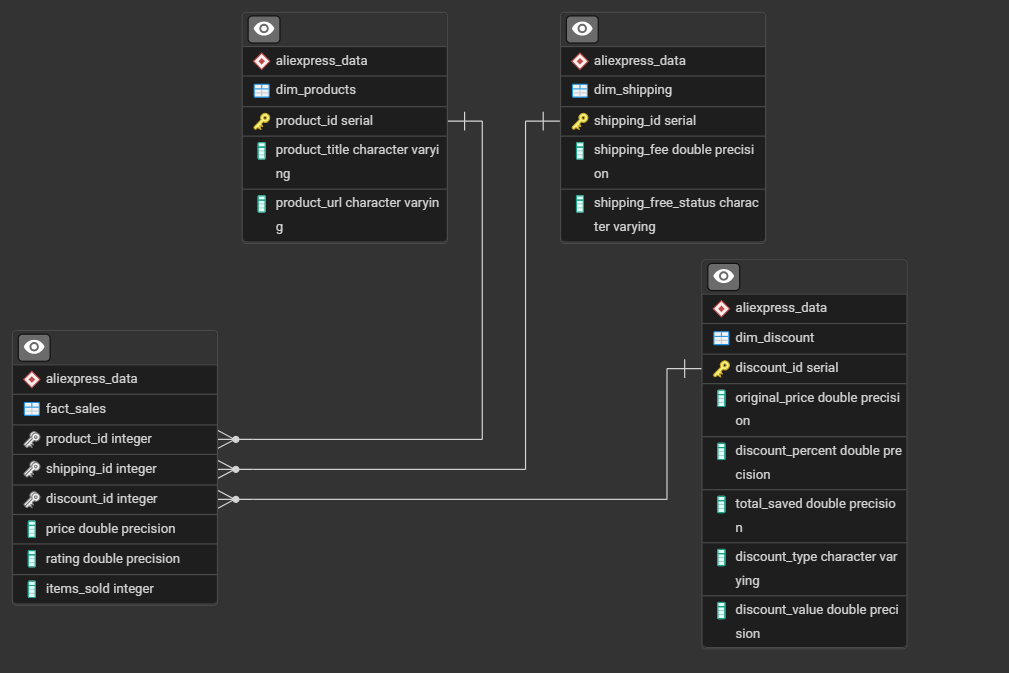

In [117]:
display(Image("alexmodel.png"))

### Transformation Layer

#### Load data from CSV file


In [107]:
#df = pd.read_csv('aliexpress_results.csv')

In [108]:
display(df.columns)
print(df.shape)
display(df.info())

Index(['Product Title', 'Price', 'Original Price', 'Discount %',
       'Extra Discount', 'Rating', 'Items Sold', 'Total Saved', 'Shipping Fee',
       'Shipping Free Status', 'Product url'],
      dtype='object')

(1015, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Product Title         1015 non-null   object 
 1   Price                 1015 non-null   object 
 2   Original Price        1009 non-null   object 
 3   Discount %            794 non-null    object 
 4   Extra Discount        205 non-null    object 
 5   Rating                618 non-null    float64
 6   Items Sold            834 non-null    object 
 7   Total Saved           476 non-null    object 
 8   Shipping Fee          875 non-null    object 
 9   Shipping Free Status  875 non-null    object 
 10  Product url           997 non-null    object 
dtypes: float64(1), object(10)
memory usage: 87.4+ KB


None

#### Cleaning raw

In [109]:
# --- Normalize and transform ---
'''Index(['Product Title', 'Price', 'Original Price', 'Discount %',
       'Extra Discount', 'Rating', 'Items Sold', 'Total Saved', 'Shipping Fee',
       'Shipping Free Status', 'Product url'],
      dtype='object'''

# Helper: Clean currency columns
def clean_currency(series):
    return (series.astype(str)
            .str.replace(r"[^\d.]", "", regex=True)
            .replace("", np.nan)
            .astype(float))

In [128]:
# Clean numeric fields using helper
df_clean=df.copy()

df_clean["Price"] = clean_currency(df_clean["Price"])
df_clean["Original Price"] = clean_currency(df_clean["Original Price"])
df_clean["Total Saved"] = clean_currency(df_clean["Total Saved"])
df_clean["Discount %"] = df_clean["Discount %"].astype(str).str.replace("%", "").replace("", np.nan).astype(float)
df_clean["Items Sold"] = df_clean["Items Sold"].astype(str).str.extract(r"(\d+)").fillna(0).astype(int)
df_clean["Rating"] = df_clean["Rating"].replace("", np.nan).astype(float)


In [129]:
# Fix shipping fee
# Normalize all text to lowercase for consistent comparison
df_clean["Extra Discount"] = df_clean["Extra Discount"].fillna("None")
df_clean["Shipping Free Status"] = df_clean["Shipping Free Status"].astype(str).str.strip()
df_clean["Extra Discount"] = df_clean["Extra Discount"].astype(str).str.strip()

# 1. If Extra Discount says 'free shipping'
mask_free = df_clean["Extra Discount"].str.lower() == "free shipping"
df_clean.loc[mask_free, "Shipping Free Status"] = "Free Shipping"
df_clean.loc[mask_free, "Shipping Fee"] = 0.0
df_clean.loc[mask_free, "Extra Discount"] = "None"

# 2. If Shipping Free Status says 'extra X% off with coins'
mask_extra_discount = df_clean["Shipping Free Status"].str.lower().str.contains(r"extra \\d+% off with coins", regex=True, na=False)
df_clean.loc[mask_extra_discount, "Extra Discount"] = df_clean.loc[mask_extra_discount, "Shipping Free Status"]
df_clean.loc[mask_extra_discount, "Shipping Free Status"] = "Not Provided"
df_clean.loc[mask_extra_discount, "Shipping Fee"] = -1.0

# 3. All other cases not marked explicitly as 'Free Shipping'
mask_not_free = ~df_clean["Shipping Free Status"].str.lower().eq("free shipping")
df_clean.loc[mask_not_free, "Shipping Free Status"] = "Not Provided"
df_clean.loc[mask_not_free, "Shipping Fee"] = -1.0

df_clean["Shipping Fee"] = df_clean["Shipping Fee"].astype(float)

display(df_clean)

,Product Title,Price,Original Price,Discount %,Extra Discount,Rating,Items Sold,Total Saved,Shipping Fee,Shipping Free Status,Product url
0,"SUXI MantaBook Pro [Limited-Time Deal] 15.6"" ...",165.59,331.16,-49.0,None,NaN,0,NaN,0.0,Free Shipping,https://www.aliexpress.com/item/10050090877049...
1,"SUXI MantaBook Pro 15.6"" Large-Screen Busines...",160.39,320.68,-49.0,None,NaN,0,NaN,0.0,Free Shipping,https://www.aliexpress.com/item/10050090872966...
2,15.6-inch Laptop Windows 11 16GB RAM DDR4 2TB ...,189.61,379.98,-50.0,None,5.0,58,190.37,0.0,Free shipping,https://www.aliexpress.com/item/10050088051563...
3,"14.1"" Ultra Slim Laptop 16GB RAM 2TB SSD Intel...",164.89,216.96,-24.0,Extra 5% off with coins,4.7,102,NaN,0.0,Free shipping,https://www.aliexpress.com/item/10050082744147...
4,"Ultra Slim Laptop 14.1"" 16GB RAM 2TB SSD Intel...",165.56,220.75,-25.0,None,4.8,500,NaN,0.0,Free shipping,https://www.aliexpress.com/item/10050067535888...
...,...,...,...,...,...,...,...,...,...,...,...
1010,2023 Gaming Notebooks I9 Laptops Computer PC W...,662.99,736.66,-10.0,Extra 5% off with coins,NaN,0,NaN,0.0,Free shipping,https://www.aliexpress.com/item/10050057370297...
1011,Lenovo 2025 NEW YOGA Air 14 Aura Ultra7-258V 3...,1849.39,2175.75,-14.0,None,5.0,3,NaN,0.0,Free shipping,https://www.aliexpress.com/item/10050056166127...
1012,Lenovo Legion Y9000P 2023 Gaming Laptop 13th I...,1519.81,2268.94,-33.0,None,NaN,1,749.13,0.0,Free shipping,https://www.aliexpress.com/item/10050060789960...
1013,OneXPlayer ONEXFLY AMD 8840U PC Handheld Game ...,1112.39,2022.53,-45.0,None,NaN,2,NaN,0.0,Free shipping,https://www.aliexpress.com/item/10050063629515...


##### Handle null

In [130]:
df_clean.isnull().sum()

Product Title             0
Price                     0
Original Price            6
Discount %              221
Extra Discount            0
Rating                  397
Items Sold                0
Total Saved             539
Shipping Fee              0
Shipping Free Status      0
Product url              18
dtype: int64

In [131]:
# If Original Price and Total Saved are both null, assign Original Price = Price
mask1 = df_clean["Original Price"].isna() & df_clean["Total Saved"].isna()
df_clean.loc[mask1, "Original Price"] = df_clean.loc[mask1, "Price"]

# If Original Price is null but Total Saved is known → Original Price = Price + Total Saved
mask2 = df_clean["Original Price"].isna() & df_clean["Total Saved"].notna()
df_clean.loc[mask2, "Original Price"] = (df_clean.loc[mask2, "Price"] + df_clean.loc[mask2, "Total Saved"]).round(2)

# If Total Saved is null → compute it from (Original Price - Price)
mask3 = df_clean["Total Saved"].isna()
df_clean.loc[mask3, "Total Saved"] = (df_clean.loc[mask3, "Original Price"] - df_clean.loc[mask3, "Price"]).round(2)
df_clean.isnull().sum()

Product Title             0
Price                     0
Original Price            0
Discount %              221
Extra Discount            0
Rating                  397
Items Sold                0
Total Saved               0
Shipping Fee              0
Shipping Free Status      0
Product url              18
dtype: int64

In [132]:
df_clean["Total Saved"] = df_clean["Total Saved"].fillna((df_clean["Original Price"] - df_clean["Price"])).round(2)
df_clean["Rating"] = df_clean["Rating"].fillna(0.0)
df_clean["Discount %"] = df_clean["Discount %"].fillna(0.0)

for col in df_clean.select_dtypes(include='object').columns:
    df_clean[col] = df_clean[col].str.lower().str.strip()


display(df_clean.isnull().sum())
display(df_clean.info())
display(df_clean)

Product Title            0
Price                    0
Original Price           0
Discount %               0
Extra Discount           0
Rating                   0
Items Sold               0
Total Saved              0
Shipping Fee             0
Shipping Free Status     0
Product url             18
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Product Title         1015 non-null   object 
 1   Price                 1015 non-null   float64
 2   Original Price        1015 non-null   float64
 3   Discount %            1015 non-null   float64
 4   Extra Discount        1015 non-null   object 
 5   Rating                1015 non-null   float64
 6   Items Sold            1015 non-null   int32  
 7   Total Saved           1015 non-null   float64
 8   Shipping Fee          1015 non-null   float64
 9   Shipping Free Status  1015 non-null   object 
 10  Product url           997 non-null    object 
dtypes: float64(6), int32(1), object(4)
memory usage: 83.4+ KB


None

,Product Title,Price,Original Price,Discount %,Extra Discount,Rating,Items Sold,Total Saved,Shipping Fee,Shipping Free Status,Product url
0,"suxi mantabook pro [limited-time deal] 15.6"" ...",165.59,331.16,-49.0,none,0.0,0,165.57,0.0,free shipping,https://www.aliexpress.com/item/10050090877049...
1,"suxi mantabook pro 15.6"" large-screen busines...",160.39,320.68,-49.0,none,0.0,0,160.29,0.0,free shipping,https://www.aliexpress.com/item/10050090872966...
2,15.6-inch laptop windows 11 16gb ram ddr4 2tb ...,189.61,379.98,-50.0,none,5.0,58,190.37,0.0,free shipping,https://www.aliexpress.com/item/10050088051563...
3,"14.1"" ultra slim laptop 16gb ram 2tb ssd intel...",164.89,216.96,-24.0,extra 5% off with coins,4.7,102,52.07,0.0,free shipping,https://www.aliexpress.com/item/10050082744147...
4,"ultra slim laptop 14.1"" 16gb ram 2tb ssd intel...",165.56,220.75,-25.0,none,4.8,500,55.19,0.0,free shipping,https://www.aliexpress.com/item/10050067535888...
...,...,...,...,...,...,...,...,...,...,...,...
1010,2023 gaming notebooks i9 laptops computer pc w...,662.99,736.66,-10.0,extra 5% off with coins,0.0,0,73.67,0.0,free shipping,https://www.aliexpress.com/item/10050057370297...
1011,lenovo 2025 new yoga air 14 aura ultra7-258v 3...,1849.39,2175.75,-14.0,none,5.0,3,326.36,0.0,free shipping,https://www.aliexpress.com/item/10050056166127...
1012,lenovo legion y9000p 2023 gaming laptop 13th i...,1519.81,2268.94,-33.0,none,0.0,1,749.13,0.0,free shipping,https://www.aliexpress.com/item/10050060789960...
1013,onexplayer onexfly amd 8840u pc handheld game ...,1112.39,2022.53,-45.0,none,0.0,2,910.14,0.0,free shipping,https://www.aliexpress.com/item/10050063629515...


In [134]:
cols = ['Discount %','Extra Discount', 'Rating',   'Shipping Fee',
       'Shipping Free Status']

for col in cols:
    print(f"\n Unique values in '{col}':")
    print(df_clean[col].unique())


 Unique values in 'Discount %':
[-49. -50. -24. -25. -20. -13.   0. -35. -16. -30. -65. -40. -54. -46.
 -10. -53. -15. -52. -21. -39. -51. -23. -29. -60. -44.  -9. -62. -47.
  -5. -45. -26. -32. -31. -33. -37. -61. -42. -41. -34. -28. -22. -19.
 -14.  -6. -87. -11. -63. -59. -67. -66. -71. -57. -79. -75. -73. -68.
 -18. -83. -55. -58.  -8. -27. -38. -91. -70. -56. -69. -12.  -7. -81.
 -36. -78. -74. -72. -88. -76. -17. -43. -64. -48.]

 Unique values in 'Extra Discount':
['none' 'extra 5% off with coins' '6 × ￡45.96 with no interest'
 'extra 3% off with coins' "sellers' pick" '6 × ￡37.19 with no interest'
 '6 × ￡28.36 with no interest' '6 × ￡44.93 with no interest'
 'extra 2% off with coins' '6 × ￡306.29 with no interest'
 '6 × ￡67.33 with no interest' '6 × ￡247.93 with no interest'
 '6 × ￡39.36 with no interest' '6 × ￡5.98 with no interest'
 '6 × ￡237.83 with no interest' '6 × ￡43.69 with no interest'
 '6 × ￡44.23 with no interest' '6 × ￡191.36 with no interest'
 'extra 4% off with c

##### Normalise 'Extra Discount'

In [135]:
# Initialize columns
df_clean["extra_discount_type"] = "none"
df_clean["extra_discount_value"] = 0.0

# 1. Extra % off with coins
mask_percent = df_clean["Extra Discount"].str.contains(r"extra \d+% off with coins", na=False)
df_clean.loc[mask_percent, "extra_discount_type"] = "coins"
df_clean.loc[mask_percent, "extra_discount_value"] = df_clean.loc[mask_percent, "Extra Discount"]\
    .str.extract(r"extra (\d+)%")[0].astype(float)

# 2. Installments
mask_installment = df_clean["Extra Discount"].str.contains(r"\d+ ×", na=False)
df_clean.loc[mask_installment, "extra_discount_type"] = "installment"
df_clean.loc[mask_installment, "extra_discount_value"] = df_clean.loc[mask_installment, "Extra Discount"]\
    .str.extract(r"(\d+) ×")[0].astype(float)

# 3. Seller labels (e.g., sellers' pick)
mask_label = df_clean["Extra Discount"].str.contains("pick|label|deal", na=False)
df_clean.loc[mask_label, "extra_discount_type"] = "label"

# Final cleanup for nulls
#df_clean["extra_discount_value"] = df_clean["extra_discount_value"].fillna(0.0).astype(float)

display(df_clean)

,Product Title,Price,Original Price,Discount %,Extra Discount,Rating,Items Sold,Total Saved,Shipping Fee,Shipping Free Status,Product url,extra_discount_type,extra_discount_value
0,"suxi mantabook pro [limited-time deal] 15.6"" ...",165.59,331.16,-49.0,none,0.0,0,165.57,0.0,free shipping,https://www.aliexpress.com/item/10050090877049...,none,0.0
1,"suxi mantabook pro 15.6"" large-screen busines...",160.39,320.68,-49.0,none,0.0,0,160.29,0.0,free shipping,https://www.aliexpress.com/item/10050090872966...,none,0.0
2,15.6-inch laptop windows 11 16gb ram ddr4 2tb ...,189.61,379.98,-50.0,none,5.0,58,190.37,0.0,free shipping,https://www.aliexpress.com/item/10050088051563...,none,0.0
3,"14.1"" ultra slim laptop 16gb ram 2tb ssd intel...",164.89,216.96,-24.0,extra 5% off with coins,4.7,102,52.07,0.0,free shipping,https://www.aliexpress.com/item/10050082744147...,coins,5.0
4,"ultra slim laptop 14.1"" 16gb ram 2tb ssd intel...",165.56,220.75,-25.0,none,4.8,500,55.19,0.0,free shipping,https://www.aliexpress.com/item/10050067535888...,none,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,2023 gaming notebooks i9 laptops computer pc w...,662.99,736.66,-10.0,extra 5% off with coins,0.0,0,73.67,0.0,free shipping,https://www.aliexpress.com/item/10050057370297...,coins,5.0
1011,lenovo 2025 new yoga air 14 aura ultra7-258v 3...,1849.39,2175.75,-14.0,none,5.0,3,326.36,0.0,free shipping,https://www.aliexpress.com/item/10050056166127...,none,0.0
1012,lenovo legion y9000p 2023 gaming laptop 13th i...,1519.81,2268.94,-33.0,none,0.0,1,749.13,0.0,free shipping,https://www.aliexpress.com/item/10050060789960...,none,0.0
1013,onexplayer onexfly amd 8840u pc handheld game ...,1112.39,2022.53,-45.0,none,0.0,2,910.14,0.0,free shipping,https://www.aliexpress.com/item/10050063629515...,none,0.0


In [136]:
# convert all column names in your df_clean DataFrame to snake_case
df_clean.columns = (
    df_clean.columns
    .str.strip()
    .str.lower()
    .str.replace(r"[^\w\s]", "", regex=True)  # remove special chars
    .str.replace(r"\s+", "_", regex=True)     # replace whitespace with underscore
)
df_clean = df_clean.rename(columns={
    "discount_": "discount_percent"})
df_clean.columns 

Index(['product_title', 'price', 'original_price', 'discount_percent',
       'extra_discount', 'rating', 'items_sold', 'total_saved', 'shipping_fee',
       'shipping_free_status', 'product_url', 'extra_discount_type',
       'extra_discount_value'],
      dtype='object')

####  Create db Tables df

##### --- Dimension Tables ---

In [137]:
# Products dimension
dim_products = df_clean[["product_title", "product_url"]].drop_duplicates().reset_index(drop=True)
dim_products["product_id"] = dim_products.index + 1

# Shipping dimension
dim_shipping = df_clean[["shipping_fee", "shipping_free_status"]].drop_duplicates().reset_index(drop=True)
dim_shipping["shipping_id"] = dim_shipping.index + 1

# Discounts dimension
dim_discount = df_clean[[
    "original_price","discount_percent","total_saved","extra_discount_type", "extra_discount_value"]].drop_duplicates().reset_index(drop=True)
dim_discount["discount_id"] = dim_discount.index + 1



In [138]:
display(dim_products.head(3))
display(dim_shipping.head(3))
display(dim_discount.head(3))

,product_title,product_url,product_id
0,"suxi mantabook pro [limited-time deal] 15.6"" ...",https://www.aliexpress.com/item/10050090877049...,1
1,"suxi mantabook pro 15.6"" large-screen busines...",https://www.aliexpress.com/item/10050090872966...,2
2,15.6-inch laptop windows 11 16gb ram ddr4 2tb ...,https://www.aliexpress.com/item/10050088051563...,3


,shipping_fee,shipping_free_status,shipping_id
0,0.0,free shipping,1
1,-1.0,not provided,2


,original_price,discount_percent,total_saved,extra_discount_type,extra_discount_value,discount_id
0,331.16,-49.0,165.57,none,0.0,1
1,320.68,-49.0,160.29,none,0.0,2
2,379.98,-50.0,190.37,none,0.0,3


##### --- Fact Table ---

In [139]:
fact_sales = df_clean.merge(dim_products, on=["product_title", "product_url"]) \
                     .merge(dim_shipping, on=["shipping_fee", "shipping_free_status"]) \
                     .merge(dim_discount, on=[
                         "original_price", "discount_percent", "total_saved", "extra_discount_type", "extra_discount_value"
                     ])

fact_sales = fact_sales[[
    "product_id", "shipping_id", "discount_id", "price", "rating", "items_sold"
]]

fact_sales

,product_id,shipping_id,discount_id,price,rating,items_sold
0,1,1,1,165.59,0.0,0
1,2,1,2,160.39,0.0,0
2,3,1,3,189.61,5.0,58
3,4,1,4,164.89,4.7,102
4,5,1,5,165.56,4.8,500
...,...,...,...,...,...,...
1010,1011,1,772,662.99,0.0,0
1011,1012,1,773,1849.39,5.0,3
1012,1013,1,774,1519.81,0.0,1
1013,1014,1,87,1112.39,0.0,2


### Loading Layer

In [140]:
target_schema_name = "aliexpress_data"
postgres_url = os.getenv("BASE_URL")

try:
    conn = psycopg2.connect(postgres_url)
    conn.autocommit = True
    cursor = conn.cursor()

    # Create schema if it doesn't exist
    cursor.execute(
        sql.SQL("CREATE SCHEMA IF NOT EXISTS {}").format(sql.Identifier(target_schema_name))
    )

    print(f"✅ Schema '{target_schema_name}' created or already exists.")

except Exception as e:
    print(f"❌ Error: {e}")
finally:
    if conn:
        cursor.close()
        conn.close()

✅ Schema 'aliexpress_data' created or already exists.


#### Create db tables with Referential Integrity

In [141]:
engine = create_engine(postgres_url)
metadata = MetaData(schema="aliexpress_data")

# Define dimension tables
products = Table("dim_products", metadata,
    Column("product_id", Integer, primary_key=True),
    Column("product_title", String),
    Column("product_url", String),
)

shipping = Table("dim_shipping", metadata,
    Column("shipping_id", Integer, primary_key=True),
    Column("shipping_fee", Float),
    Column("shipping_free_status", String),
)

discount = Table("dim_discount", metadata,
    Column("discount_id", Integer, primary_key=True),
    Column("original_price", Float),
    Column("discount_percent", Float),
    Column("total_saved", Float),
    Column("extra_discount_type", String),
    Column("extra_discount_value", Float),
)

# Define fact table with FKs
sales = Table("fact_sales", metadata,
    Column("product_id", Integer, ForeignKey("dim_products.product_id")),
    Column("shipping_id", Integer, ForeignKey("dim_shipping.shipping_id")),
    Column("discount_id", Integer, ForeignKey("dim_discount.discount_id")),
    Column("price", Float),
    Column("rating", Float),
    Column("items_sold", Integer),
)

# Create all tables in the database
metadata.create_all(engine)

##### Load data into PostgreSQL tables

In [142]:
# Save to PostgreSQL using append mode to preserve schema and constraints

with engine.begin() as connection:
    dim_products.to_sql("dim_products", con=connection, if_exists="append", index=False, schema=target_schema_name)
    dim_shipping.to_sql("dim_shipping", con=connection, if_exists="append", index=False, schema=target_schema_name)
    dim_discount.to_sql("dim_discount", con=connection, if_exists="append", index=False, schema=target_schema_name)
    fact_sales.to_sql("fact_sales", con=connection, if_exists="append", index=False, schema=target_schema_name)

print("✅ Data safely appended to PostgreSQL schema:", target_schema_name)


✅ Data safely appended to PostgreSQL schema: aliexpress_data


#### Verify Table Load

In [144]:
# read and preview the dim_products table
test_df = pd.read_sql_table("dim_products", con=engine, schema=target_schema_name)
test_df.head()


,product_id,product_title,product_url
0,1,"suxi mantabook pro [limited-time deal] 15.6"" ...",https://www.aliexpress.com/item/10050090877049...
1,2,"suxi mantabook pro 15.6"" large-screen busines...",https://www.aliexpress.com/item/10050090872966...
2,3,15.6-inch laptop windows 11 16gb ram ddr4 2tb ...,https://www.aliexpress.com/item/10050088051563...
3,4,"14.1"" ultra slim laptop 16gb ram 2tb ssd intel...",https://www.aliexpress.com/item/10050082744147...
4,5,"ultra slim laptop 14.1"" 16gb ram 2tb ssd intel...",https://www.aliexpress.com/item/10050067535888...


#### Dispose SQLAlchemy Engine

In [145]:
engine.dispose()